# Определение возраста покупателей

*Описание задачи:*
- Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


*План работ:*
- Загрузка датасета с картинками
- Анализ изображений
- Обучение модели
- Исследование результатов лучшей модели


## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import random
from random import randint

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загружаем данные
try:
    data = pd.read_csv('/datasets/faces/labels.csv')
except:
    data = pd.read_csv('datasets/faces/labels.csv')
else:
    print('Данные не найдены')

Данные не найдены


In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные загружены. Всего в датасете 7591 запись.

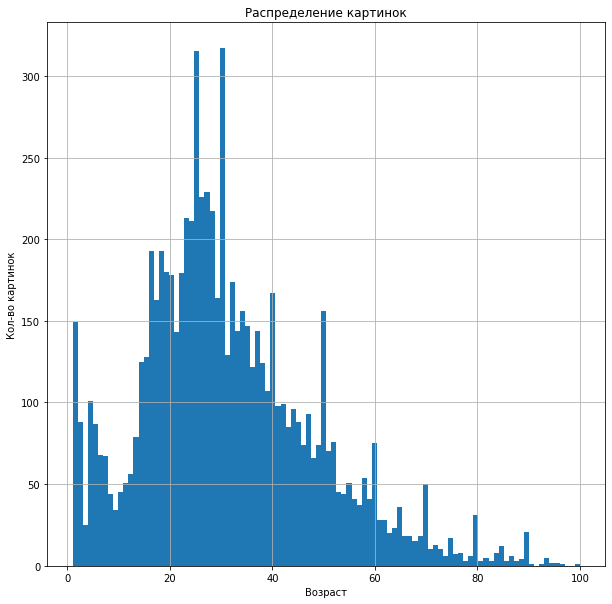

In [5]:
# график распределение картинок по возрастам
plt.figure(figsize=(10,10))
data['real_age'].hist(bins = 100)
plt.xlabel('Возраст')
plt.ylabel('Кол-во картинок')
plt.title('Распределение картинок')
plt.show()

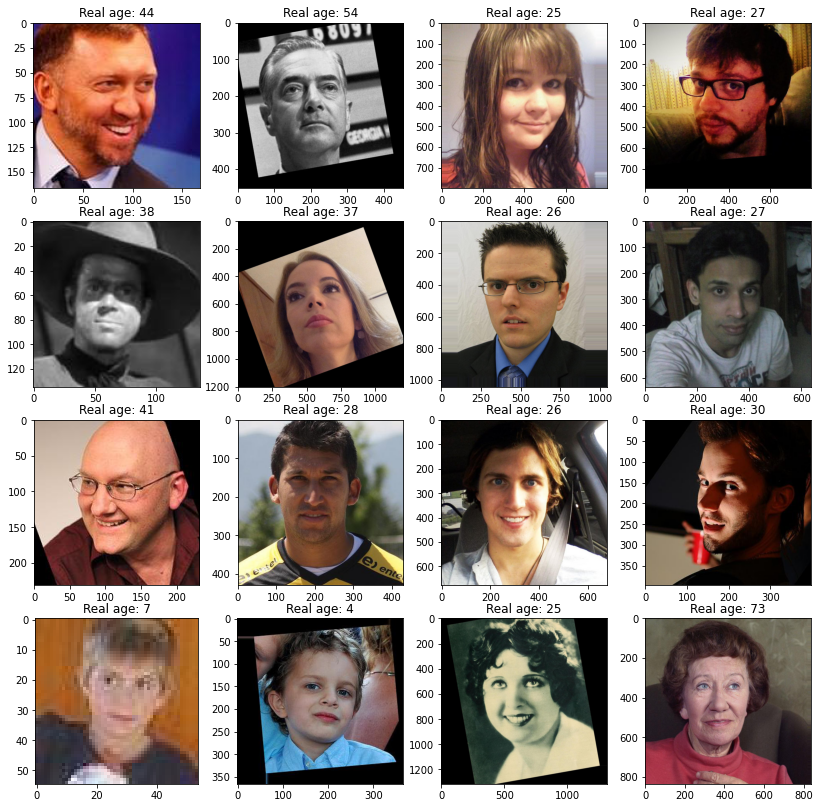

In [6]:
# построим изображения 16 случайных фотографий из нашей базы

fig = plt.figure(figsize=(14,14))

r_list = [randint(1, 7000) for x in range(16) ]
scroll = 0

for i in r_list:
    
    fig.add_subplot(4, 4, scroll+1)
    
    image = Image.open('/datasets/faces/final_files/'+data['file_name'][i])
    
    plt.imshow(image)  
    plt.title('Real age: ' + str(data['real_age'][i]))
    
    scroll += 1

In [7]:
# функции для записи размерности фотографий в датасет
def return_x_y(img):
    image = Image.open('/datasets/faces/final_files/'+img)
    return [np.array(image).shape[0], np.array(image).shape[1]] 

In [8]:
%%time
data['xy_shape'] = data['file_name'].apply(return_x_y)

CPU times: user 36.7 s, sys: 1.76 s, total: 38.4 s
Wall time: 2min


In [9]:
data['x_shape'] = data['xy_shape'].apply(lambda x: x[0])
data['y_shape'] = data['xy_shape'].apply(lambda x: x[1])

In [10]:
# возьмем среднюю размерность по фотографиям
# в дальнейшем в целях поиска оптимальной модели данный параметр
# можно будет поменять

data['x_shape'].mean(), data['y_shape'].mean()

(464.0939270188381, 464.73376366750097)

In [11]:
%%time

# загрузим выборку чере данные четез ImageDataGenerator

train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)#,
# #                                       horizontal_flip=True,
# #                                       vertical_flip=True,
# #                                       rotation_range=90,
# #                                       width_shift_range=0.2,
# #                                       height_shift_range=0.2)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

val_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)


Found 5694 validated image filenames.
Found 1897 validated image filenames.
CPU times: user 521 ms, sys: 249 ms, total: 770 ms
Wall time: 2min 40s


In [12]:
features,target=next(train_gen_flow)

In [13]:
features[0][0][0], target[0]

(array([0.8470589 , 0.85098046, 0.8313726 ], dtype=float32), 27)

**Вывод:** Был загружен датасет с фотографиями (всего 7591 изображение). Диапазон целевого значения от 1 до 100 лет. Были исследованы случайные фотографии, подсчитаны средние размерности всех фотографий. Сформирован загрузчик данных с выделением 25% вотографий под проведения теста. В дальнейшем для уменьшения времени обучения модели можно применить разложение на компоненты методом SVD или PCA, для снижения размерности картинок.

## Обучение модели

```python
import pandas as pd
from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):


    backbone = ResNet50(input_shape=(input_shape),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
   
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2024-02-28 16:51:41.556684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-28 16:51:42.865084: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 110s - loss: 200.1430 - mae: 10.2879 - val_loss: 500.0081 - val_mae: 17.2666
Epoch 2/10
356/356 - 79s - loss: 83.9681 - mae: 6.9530 - val_loss: 138.7480 - val_mae: 8.9225
Epoch 3/10
356/356 - 77s - loss: 56.7186 - mae: 5.8135 - val_loss: 105.8046 - val_mae: 8.0342
Epoch 4/10
356/356 - 79s - loss: 45.5668 - mae: 5.1010 - val_loss: 99.9251 - val_mae: 7.8171
Epoch 5/10
356/356 - 79s - loss: 34.4267 - mae: 4.4987 - val_loss: 76.2846 - val_mae: 6.3559
Epoch 6/10
356/356 - 54s - loss: 25.1278 - mae: 3.8387 - val_loss: 76.6698 - val_mae: 6.7424
Epoch 7/10
356/356 - 53s - loss: 20.5086 - mae: 3.4437 - val_loss: 67.7081 - val_mae: 6.0794
Epoch 8/10
356/356 - 55s - loss: 16.7115 - mae: 3.1129 - val_loss: 72.8460 - val_mae: 6.2519
Epoch 9/10
356/356 - 67s - loss: 14.9099 - mae: 2.9327 - val_loss: 78.2421 - val_mae: 6.6872
Epoch 10/10
356/356 - 73s - loss: 12.6252 - mae: 2.6952 - val_loss: 65.1449 - val_mae: 6.0641
WARNING:tensorflow:sample_weight modes were coerced from

119/119 - 11s - loss: 65.1449 - mae: 6.0641



```



## Анализ обученной модели

>В ходе работы были выполнены следующие операции:
>- Изучена информация о картинках для обучения модели
>- Исследован таргет обучения
>- Подобраны оптимальные параметры для модели
>- обучена лучшая модель


> В ходе исследования была изучена информация о имеющихся данных для обучения. Выбран оптимальный размер картинок (путем вычисления среднего). За основу модели была взята сеть ResNet50. Лучшая метрика MAE на тестовой выборке составляет 6.0641. Данная метрика было достигнута выставлением шага убывание градинта = 0.0001, и 10 эпох обучения. 